In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from cycler import cycler

In [64]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "tab:blue",
        "tab:red",
        "tab:purple",
        "tab:orange",
        "tab:cyan",
        "tab:pink",
        "tab:olive",
    ]
)

# Simulation Code

In [4]:
def get_quantized_value_options(
    total_bits,
    fractional_bits,
    signed=True,
    enforce_symmetry=False,
    return_min=None,
    return_max=None
):
    if signed:
        max_value = 2**(total_bits - 1) - 1
    else:
        max_value = 2**(total_bits - 1)
    if signed:
        if enforce_symmetry:
            min_value = -1 * max_value
        else:
            min_value = -(2 ** (total_bits - 1))
    else:
        min_value = 0

    if return_min is not None:
        min_value = np.max([np.round(return_min * 2**fractional_bits), min_value])
    if return_max is not None:
        max_value = np.min([np.round(return_max * 2**fractional_bits), max_value])
    return np.arange(min_value, max_value+1) / (2 ** fractional_bits)


def quantize(
    numbers,
    total_bits,
    fractional_bits,
    signed=True,
    enforce_symmetry=False,
):  # Copied from requantization_sim.ipynb

    numbers = np.asarray(numbers)
    numbers = np.round(numbers * 2**fractional_bits)
    if signed:
        max_value = 2 ** (total_bits - 1) - 1
    else:
        max_value = 2**total_bits - 1
    numbers[numbers > max_value] = max_value
    if signed:
        if enforce_symmetry:
            min_value = -1 * max_value
        else:
            min_value = -(2 ** (total_bits - 1))
        numbers[numbers < min_value] = min_value
    numbers /= 2.0**fractional_bits
    return numbers


def get_probabilities(stddev, value_options):

    probabilities = np.zeros_like(value_options)
    for ind in range(len(value_options)):
        if ind == 0:
            integral_start = -np.inf
        else:
            integral_start = (
                value_options[ind - 1]
                + value_options[ind]
            ) / 2

        if ind == len(value_options) - 1:
            integral_end = np.inf
        else:
            integral_end = (
                value_options[ind]
                + value_options[ind + 1]
            ) / 2
        integral_value = (
            np.sqrt(np.pi)
            * stddev
            / 2
            * (
                scipy.special.erf(integral_end / (np.sqrt(2) * stddev))
                - scipy.special.erf(integral_start / (np.sqrt(2) * stddev))
            )
        )
        probabilities[ind] = integral_value

    probabilities /= np.sum(probabilities)
    return probabilities


def calculate_variance(values, probabilities):
    return np.sum(probabilities * values**2) - np.sum(probabilities * values) ** 2

In [5]:
def requantization_sim(
    input_stddev_array,
    equalization_coeffs,
):

    initial_quantized_value_options = get_quantized_value_options(18, 17)
    # input_stddev_array = np.full_like(equalization_coeffs, input_stddev)

    input_stddev_unique = np.unique(input_stddev_array)
    initial_quantized_probabilities_array = np.zeros(
        (len(initial_quantized_value_options), len(input_stddev_unique))
    )
    for stddev_ind, use_stddev in enumerate(input_stddev_unique):
        initial_quantized_probabilities_array[:, stddev_ind] = get_probabilities(
            use_stddev, initial_quantized_value_options
        )

    final_quantized_value_options = get_quantized_value_options(
        4, 3, enforce_symmetry=True
    )
    final_variances = np.zeros_like(equalization_coeffs)
    for equalization_ind, equalization_coeff in enumerate(equalization_coeffs):

        initial_quantized_probabilities = initial_quantized_probabilities_array[
            :,
            np.where(input_stddev_unique == input_stddev_array[equalization_ind])[0][0],
        ]
        equalized_value_options = initial_quantized_value_options * equalization_coeff
        final_quantized_probabilities = np.zeros_like(final_quantized_value_options)
        equalized_value_options_quantized = quantize(
            equalized_value_options, 4, 3, enforce_symmetry=True
        )
        for ind in range(len(final_quantized_value_options)):
            final_quantized_probabilities[ind] = np.sum(
                initial_quantized_probabilities[
                    np.where(
                        equalized_value_options_quantized
                        == final_quantized_value_options[ind]
                    )
                ]
            )

        variance = calculate_variance(
            final_quantized_value_options, final_quantized_probabilities
        )
        final_variances[equalization_ind] = variance

    return final_variances

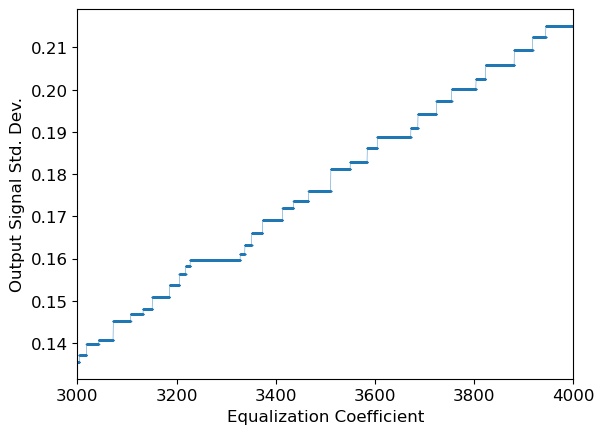

In [170]:
equalization_coeffs = np.linspace(3000, 4000, num=5000)
final_variances = requantization_sim(
    np.full_like(equalization_coeffs, 1.25e-4),
    equalization_coeffs,
)
plt.plot(
    equalization_coeffs,
    final_variances,
    ".-",
    markersize=.5,
    linewidth=0.3,
)
plt.xlim([np.min(equalization_coeffs), np.max(equalization_coeffs)])
plt.xlabel("Equalization Coefficient")
plt.ylabel("Output Signal Std. Dev.")
plt.show()

# Instrument Simulation

In [171]:
eq_coeffs_mat = scipy.io.loadmat(
    "/home/ldaddario/settings/20251028a-settingsAll-night-FW7p6.mat"
    # "/home/pipeline/opsdata/20251111b-settingsAll-day-FW7p5.mat"
)
channel_width_mhz = 23925.78125 * 1e-6
freq_array = np.arange(len(eq_coeffs_mat["coef"][ind, :])) * channel_width_mhz
for ind in range(7):
    plt.plot(freq_array, eq_coeffs_mat["coef"][ind, :], "-", linewidth=1)
plt.xlim([np.min(freq_array), np.max(freq_array)])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Equalization Coefficient")

use_eq_coeffs = eq_coeffs_mat["coef"][0, :] * 2**-4

IndexError: index 262143 is out of bounds for axis 0 with size 7

In [8]:
target_value = 3/2**3  # Ideal stddev for the 4-bit quantization
print(target_value)

0.375


Text(0, 0.5, 'Expected FFT Output Stddev')

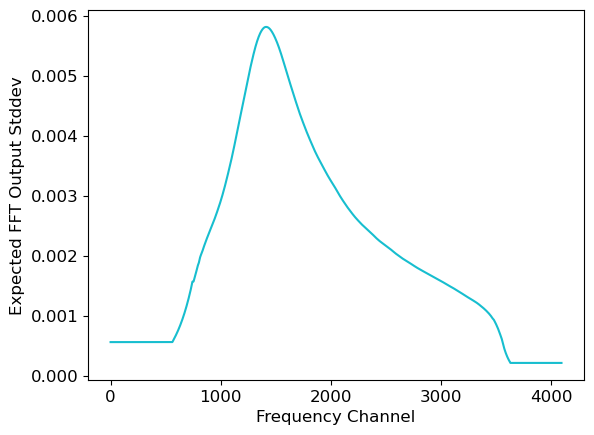

In [9]:
data_stddev = target_value / use_eq_coeffs
plt.plot(data_stddev)
plt.xlabel("Frequency Channel")
plt.ylabel("Expected FFT Output Stddev")

In [10]:
final_variances = requantization_sim(
    data_stddev[2000:2100],
    use_eq_coeffs[2000:2100],
)  # Run simulation

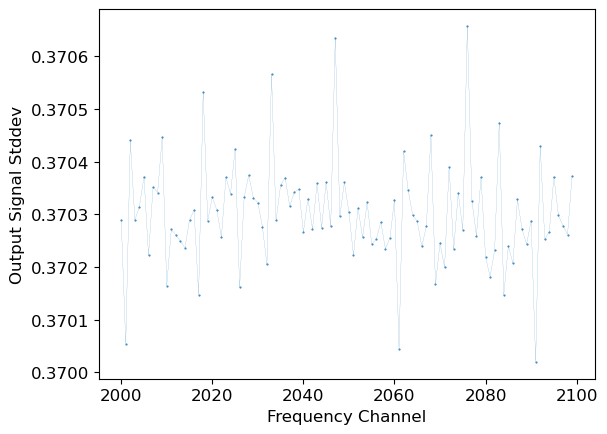

In [11]:
plt.plot(
    np.arange(2000, 2100),
    np.sqrt(final_variances),
    ".-",
    markersize=1,
    linewidth=0.1,
    color="tab:blue",
)
plt.xlabel("Frequency Channel")
plt.ylabel("Output Signal Stddev")
plt.show()

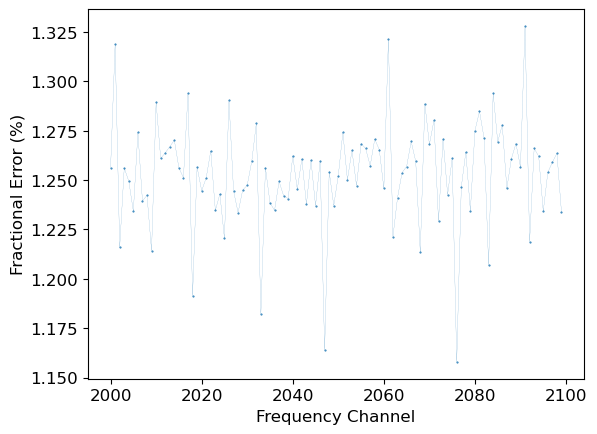

In [12]:
plt.plot(
    np.arange(2000, 2100),
    np.abs(1 - np.sqrt(final_variances) / target_value) * 100,
    ".-",
    markersize=1,
    linewidth=0.1,
    color="tab:blue",
)
plt.xlabel("Frequency Channel")
plt.ylabel("Fractional Error (%)")
plt.show()

In [13]:
print(len(final_variances))

100


# Paper Plots

Text(0, 0.5, '4-bit Quantized Value')

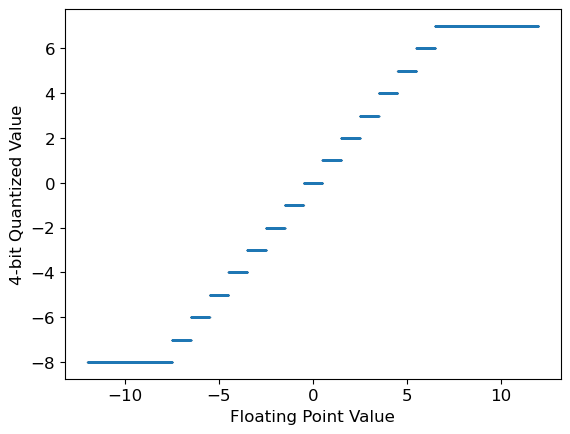

In [18]:
input_vals = np.arange(-12, 12, 0.001)
output_vals = quantize(
    input_vals,
    4,
    0,
    signed=True,
    enforce_symmetry=False,
)
plt.plot(input_vals, output_vals, ".", color="tab:blue", markersize=0.1)
plt.xlabel("Floating Point Value")
plt.ylabel("4-bit Quantized Value")
#plt.savefig("/Users/ruby/Downloads/4bit_quantization.png", dpi=300)

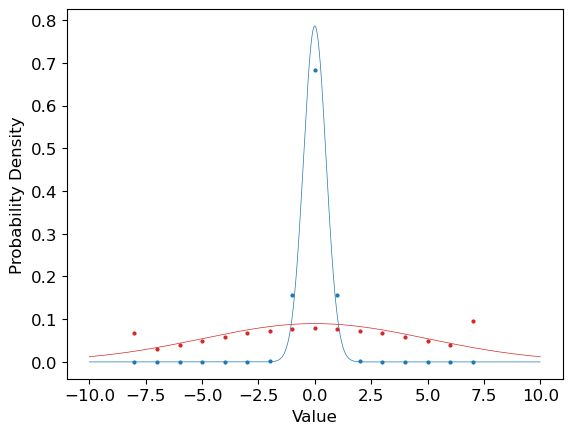

In [19]:
colors = ["tab:blue", "tab:red"]
for ind, stddev in enumerate([.5, 5]):
    color = colors[ind]
    quantized_xvals = get_quantized_value_options(
        4, 0, signed=True, enforce_symmetry=False
    )
    analytic_xvals = np.arange(-10, 10, .001)
    gaussian_analytic = np.exp(-(analytic_xvals**2) / (2 * stddev**2))
    gaussian_quantized = get_probabilities(stddev, quantized_xvals)
    gaussian_analytic /= np.sum(np.exp(-(quantized_xvals**2) / (2 * stddev**2)))
    plt.plot(analytic_xvals, gaussian_analytic, color=color, linewidth=0.5)
    plt.plot(quantized_xvals, gaussian_quantized, ".", color=color, markersize=4)
    plt.xlabel("Value")
    plt.ylabel("Probability Density")
    #plt.savefig("/Users/ruby/Downloads/quantized_probabilities.png", dpi=300)

Text(0, 0.5, '4-bit Quantized Signal Std. Dev.')

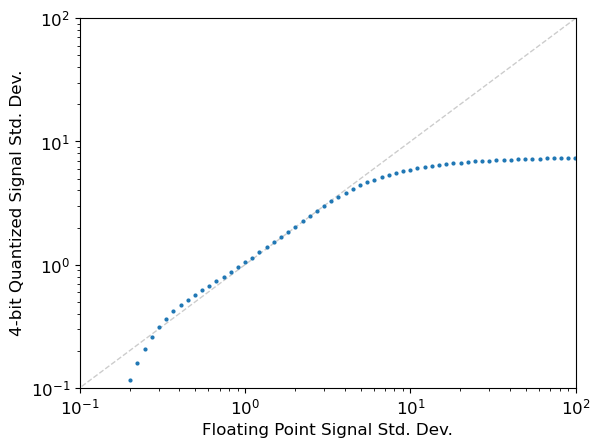

In [20]:
colors = ["tab:blue", "tab:red"]
quantized_xvals = get_quantized_value_options(4, 0, signed=True, enforce_symmetry=False)
stddev_array = np.exp(np.arange(-1e1, 1e1, 1e-1))
variance_array = np.zeros_like(stddev_array)
for ind, stddev in enumerate(stddev_array):
    probability = get_probabilities(stddev, quantized_xvals)
    variance_array[ind] = calculate_variance(quantized_xvals, probability)

plt.plot([0, 100], [0, 100], "--", color="black", alpha=0.2, linewidth=1)
plt.plot(stddev_array, np.sqrt(variance_array), ".", markersize=4, color="tab:blue")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-1,1e2])
plt.ylim([1e-1, 1e2])
plt.xlabel("Floating Point Signal Std. Dev.")
plt.ylabel("4-bit Quantized Signal Std. Dev.")
#plt.savefig("/Users/ruby/Downloads/quantized_stddev.png", dpi=300)

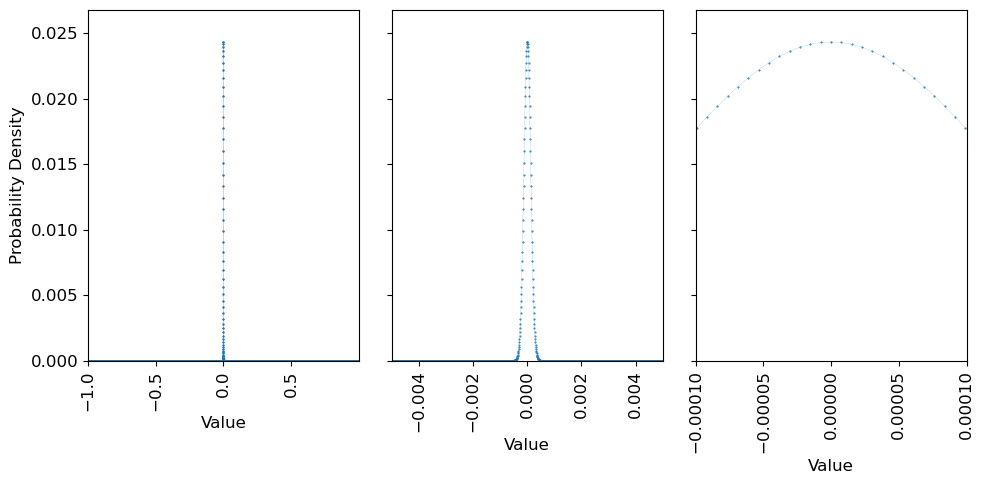

In [137]:
color = "tab:blue"
stddev = 1.25e-4
quantized_xvals = get_quantized_value_options(
    18, 17, signed=True, enforce_symmetry=False,
)
gaussian_quantized = get_probabilities(stddev, quantized_xvals)
fig,ax = plt.subplots(ncols=3, figsize=(10,5), sharey=True)
xmax = [1.1, 5e-3, 1e-4]
for ax_ind in range(3):
    ax[ax_ind].plot(
        quantized_xvals,
        gaussian_quantized,
        ".-",
        color=color,
        markersize=1,
        linewidth=0.1,
    )
    ax[ax_ind].set_xlabel("Value")
    if ax_ind == 0:
        ax[ax_ind].set_xlim([np.min(quantized_xvals), np.max(quantized_xvals)])
    else:
        ax[ax_ind].set_xlim([-xmax[ax_ind], xmax[ax_ind]])
    ax[ax_ind].set_ylim([0, 1.1 * np.max(gaussian_quantized)])
    ax[ax_ind].tick_params(axis="x", labelrotation=90)
ax[0].set_ylabel("Probability Density")
plt.tight_layout()
#plt.savefig("/Users/ruby/Downloads/pdf_nonequalized.png", dpi=300)

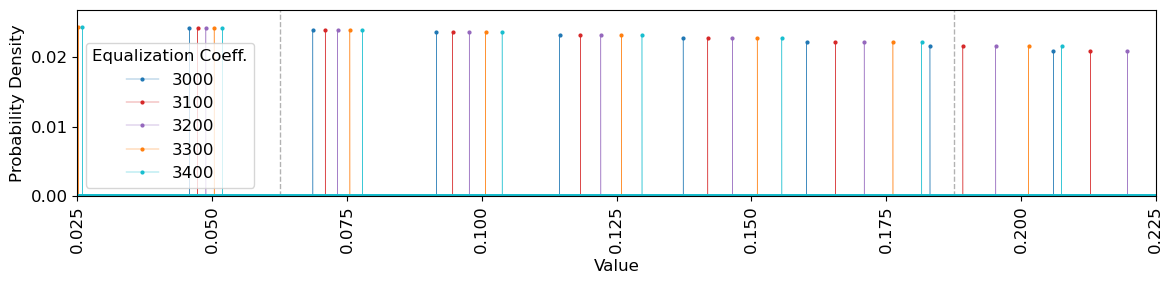

In [ ]:
xlimits = np.array([-.8, .8]) * 2**-3 + 0.125
equalized_xvals = get_quantized_value_options(
    34,
    19,
    signed=True,
    enforce_symmetry=False,
    return_min=xlimits[0],
    return_max=xlimits[1],
)
requantized_xvals = get_quantized_value_options(
    4,
    3,
    signed=True,
    enforce_symmetry=True,
)
requantized_boundaries = (requantized_xvals[1:] + requantized_xvals[:-1])/2
fig, ax = plt.subplots(figsize=(12, 3))
for requant_boundary in requantized_boundaries:
    ax.plot(
        [requant_boundary, requant_boundary],
        [0, 1.1 * np.max(gaussian_quantized)],
        "--",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
for eq_ind, equalization_coeff in enumerate([3000, 3100, 3200, 3300, 3400]):
    equalized_pdf = np.zeros_like(equalized_xvals)
    for ind in range(len(quantized_xvals)):
        equalized_pdf[np.where(equalized_xvals == quantized_xvals[ind]*equalization_coeff)[0]] = gaussian_quantized[ind] 
    ax.plot(
        equalized_xvals,
        equalized_pdf,
        ".-",
        markersize=4,
        linewidth=0.3,
        label=equalization_coeff,
    )
ax.set_xlim([xlimits[0], xlimits[1]])
ax.set_ylim([0, 1.1 * np.max(gaussian_quantized)])
ax.tick_params(axis="x", labelrotation=90)
ax.legend(title="Equalization Coeff.")
ax.set_xlabel("Value")
ax.set_ylabel("Probability Density")
plt.tight_layout()
# plt.savefig("/Users/ruby/Downloads/pdf_equalized.png", dpi=300)

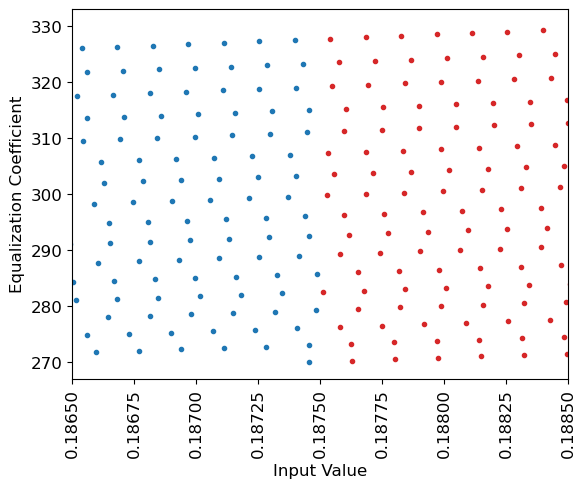

In [ ]:
equalization_coeffs = get_quantized_value_options(
    16,
    2,
    signed=False,
    enforce_symmetry=False,
    return_min=270,
    return_max=330,
)
for eq_coeff in equalization_coeffs:
    quantized_xvals1 = (quantized_xvals * eq_coeff)[
        np.where(quantized_xvals * eq_coeff < 0.1875)
    ]
    quantized_xvals2 = (quantized_xvals * eq_coeff)[
        np.where(quantized_xvals * eq_coeff > 0.1875)
    ]
    plt.plot(
        quantized_xvals1,
        np.full_like(quantized_xvals1, eq_coeff),
        ".",
        color="tab:blue",
    )
    plt.plot(
        quantized_xvals2,
        np.full_like(quantized_xvals2, eq_coeff),
        ".",
        color="tab:red",
    )
plt.xlim([0.1875-.001, 0.1875+.001])
plt.xlabel("Input Value")
plt.ylabel("Equalization Coefficient")
plt.tick_params(axis="x", labelrotation=90)

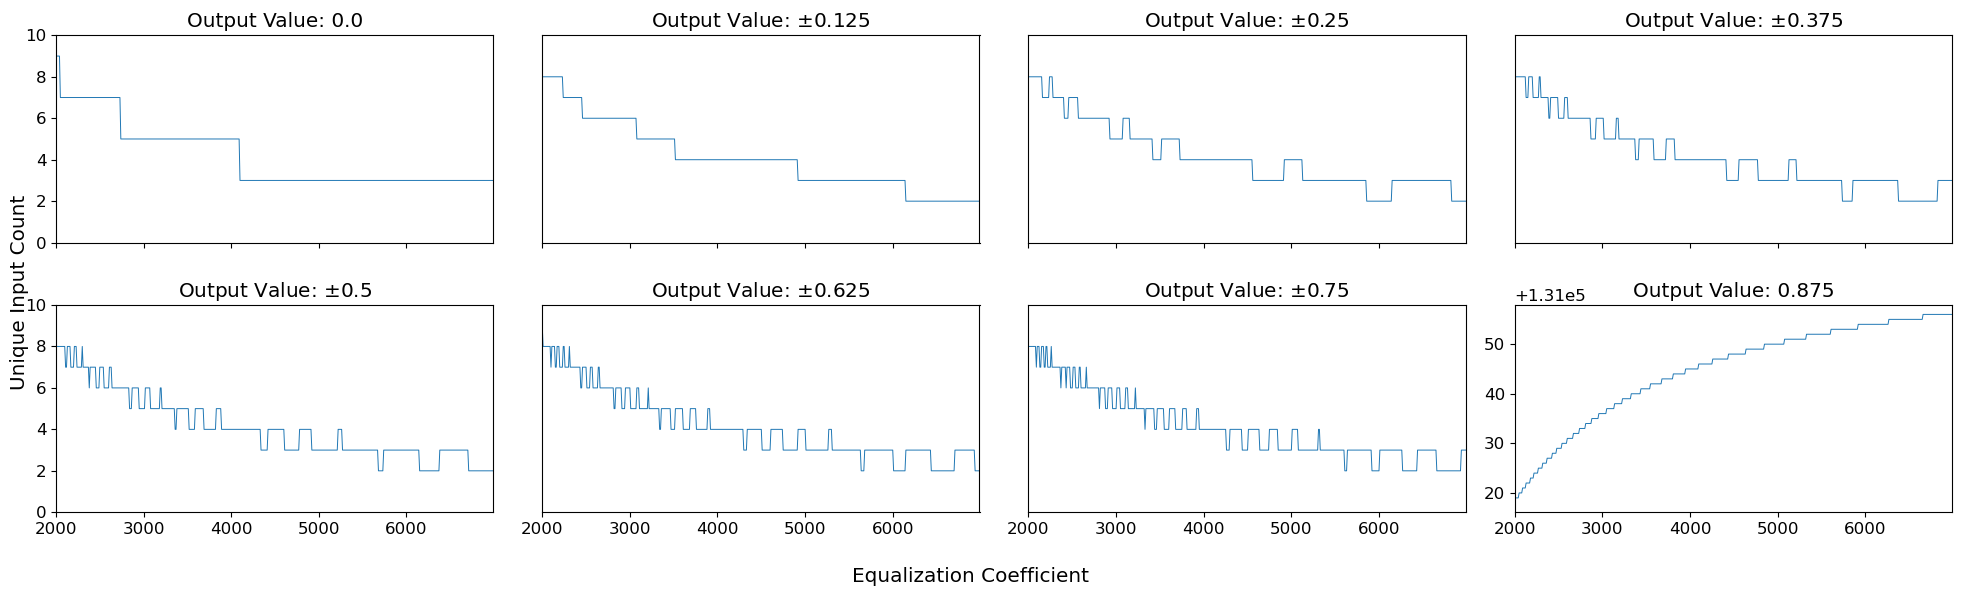

In [121]:
eq_coeffs = np.arange(2000, 7000, 10)
use_requantized_value_options = get_quantized_value_options(
    4,
    3,
    signed=True,
    enforce_symmetry=True,
)
number_of_values = np.zeros((len(eq_coeffs), len(use_requantized_value_options)), dtype=int)

for coeff_ind, eq_coeff in enumerate(eq_coeffs):
    requantized_values = quantize(
        quantized_xvals * eq_coeff,
        4,
        3,
        signed=True,
        enforce_symmetry=True,
    )
    requantized_value_options = get_quantized_value_options(
        4,
        3,
        signed=True,
        enforce_symmetry=True,
    )
    for output_ind, output in enumerate(use_requantized_value_options):
        number_of_values[coeff_ind, output_ind] = len(
            np.where(requantized_values == output)[0]
        )

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 6), sharey=False, sharex=True)
plot_requantized_inds = [7, 8, 9, 10, 11, 12, 13, 14]
for plot_ind, output_ind in enumerate(plot_requantized_inds):
    output_value = use_requantized_value_options[output_ind]
    use_ax = ax.flatten()[plot_ind]
    use_ax.plot(
        eq_coeffs,
        number_of_values[:, output_ind],
        "-",
        linewidth=.7,
        label=use_requantized_value_options[output_ind],
    )
    if output_ind in [7, 14]:
        use_ax.set_title(f"Output Value: {output_value}")
    else:
        use_ax.set_title(f"Output Value: $\pm${output_value}")
    if output_ind not in [7, 11, 14]:
        use_ax.get_yaxis().set_visible(False)
    use_ax.set_xlim([np.min(eq_coeffs), np.max(eq_coeffs)])
    if output_ind != 14:
        use_ax.set_ylim([0, 10])

fig.supxlabel("Equalization Coefficient")
fig.supylabel("Unique Input Count")
plt.tight_layout()

In [150]:
def get_requantized_probabilities(
    input_stddev_array,
    equalization_coeffs,
):

    initial_quantized_value_options = get_quantized_value_options(18, 17)

    input_stddev_unique = np.unique(input_stddev_array)
    initial_quantized_probabilities_array = np.zeros(
        (len(initial_quantized_value_options), len(input_stddev_unique))
    )
    for stddev_ind, use_stddev in enumerate(input_stddev_unique):
        initial_quantized_probabilities_array[:, stddev_ind] = get_probabilities(
            use_stddev, initial_quantized_value_options
        )

    final_quantized_value_options = get_quantized_value_options(
        4, 3, enforce_symmetry=True
    )
    final_quantized_probabilities = np.zeros(
        (len(final_quantized_value_options), len(equalization_coeffs))
    )
    for equalization_ind, equalization_coeff in enumerate(equalization_coeffs):

        initial_quantized_probabilities = initial_quantized_probabilities_array[
            :,
            np.where(input_stddev_unique == input_stddev_array[equalization_ind])[0][0],
        ]
        equalized_value_options = initial_quantized_value_options * equalization_coeff
        equalized_value_options_quantized = quantize(
            equalized_value_options, 4, 3, enforce_symmetry=True
        )
        for ind in range(len(final_quantized_value_options)):
            final_quantized_probabilities[ind, equalization_ind] = np.sum(
                initial_quantized_probabilities[
                    np.where(
                        equalized_value_options_quantized
                        == final_quantized_value_options[ind]
                    )
                ]
            )

    return final_quantized_value_options, final_quantized_probabilities

In [151]:
eq_coeffs = np.array([3000, 3100, 3200, 3300, 3400])
final_quantized_value_options, final_quantized_probabilities = (
    get_requantized_probabilities(
        np.full_like(eq_coeffs, 0.000125, dtype=float),
        eq_coeffs,
    )
)

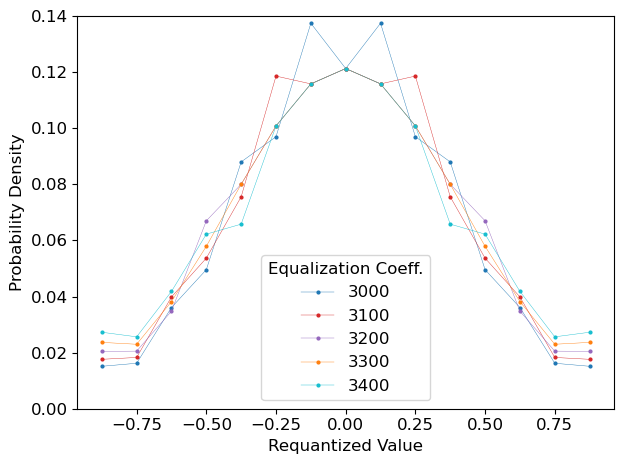

In [160]:
for coeff_ind, eq_coeff in enumerate(eq_coeffs):
    plt.plot(
        final_quantized_value_options,
        final_quantized_probabilities[:, coeff_ind],
        ".-",
        markersize=4,
        linewidth=0.3,
        label=eq_coeff,
    )
plt.xlabel("Requantized Value")
plt.ylabel("Probability Density")
plt.legend(title="Equalization Coeff.")
plt.ylim([0,0.14])
plt.tight_layout()